# Style Transfer with Deep Neural Networks


Style transfer는 content image 와 style image가 주어졌을 때 이미지의 윤곽, 형태는 content image와 유사하게, color 또는 texture 는 style image와 유사하게 바꾸는 것을 의미한다.  
content와 style을 분리하여 다른 이미지끼리의 content와 style을 섞을 수 있다.  

이 실습에서는 19-layer VGG Network를 사용하여 Style Transfer를 구현한다.  

 아래 이미지에서 컨벌루션 레이어의 이름은 스택 및 스택의 순서에 따라 지정된다. Conv_1_1은 첫 번째 스택에서 이미지가 전달되는 첫 번째 컨볼루션 레이어이다. Conv_2_1은 두번째 스택에서 첫 번째 컨볼루션 레이어다. 네트워크에서 가장 깊은 컨볼루션 레이어는 conv_5_4이다.



<img src='../assets/vgg19_convlayers.png' width=80% />

### Separating Style and Content

Style Transfer에서는 content와 style을 분리하여 다른 이미지끼리의 content와 style을 섞을 수 있다.

하나의 컨텐츠 이미지와 하나의 스타일 이미지가 주어지면 원하는 컨텐츠 및 스타일 구성 요소를 조합하여 새로운 target 이미지를 작성한다.


* **content image** : 이미지를 구성하는 주된 형태
* **style image** : 스타일, 색깔, 텍스쳐 등

content image 와 style image가 주어졌을 때 그 이미지의 주된 형태는 content image와 유사하게 유지하면서 스타일만 우리가 원하는 style image와 유사하게 바꾸는 것을 말한다. 


아래 예제에서 보듯이 고양이 사진을 content image로 하고 [Hokusai's Great Wave](https://en.wikipedia.org/wiki/The_Great_Wave_off_Kanagawa).을 style image로 하여 새로운 target image를 생성한다. 생성된 target image는 여전히 고양이의 형태를 유지하지만 색깔, texture 등은 sytle image의 것으로 대체되었다.

<img src='../assets/style_tx_cat.png' width=80% />

이번 실습에서 pre-trained VGG19 Net을 content, style을 추출하는 모형으로 사용한다. 그런 다음 content와 style의 losses를 사용하여 원하는 결과를 얻을 때까지 대상 이미지를 반복적으로 업데이트한다.  

In [1]:
# import resources
%matplotlib inline

from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import requests
from torchvision import transforms, models

## Load in VGG19 (features)

VGG19 는 두 부분으로 나뉘어 있다.:
* `vgg19.features`, 모든 convolutional layer와 pooling layers
* `vgg19.classifier`, 맨 마지막 3개의 linear layer로 classifier layer이다.

우리는 `features` 부분만 필요하다.  그리고 weight가 update되지 않도록 "freeze"한다.

In [2]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
import os

os.environ['TORCH_HOME'] = '../models'

vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to ../models\checkpoints\vgg19-dcbb9e9d.pth


In [3]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Load in Content and Style Images

Style transfer에 사용할  content image와 style image를 로드한다. 
`load_image` function이 해당 image를 변환하여 normalized Tensors 형태로 load한다.


추가적으로, 사이즈가 큰 이미지를 사용하면 학습 시간이 오래 걸릴 수 있다.   
그리고 content와 style image를 같은 사이즈로 해야 한다.

In [4]:
def load_image(img_path, max_size=128, shape=None): # GPU로 학습하면 400
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

content 이미지와 style 이미지를 load한다.

In [5]:
# load in content and style image
content = load_image('images/octopus.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('images/hockney.jpg', shape=content.shape[-2:]).to(device)

In [6]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

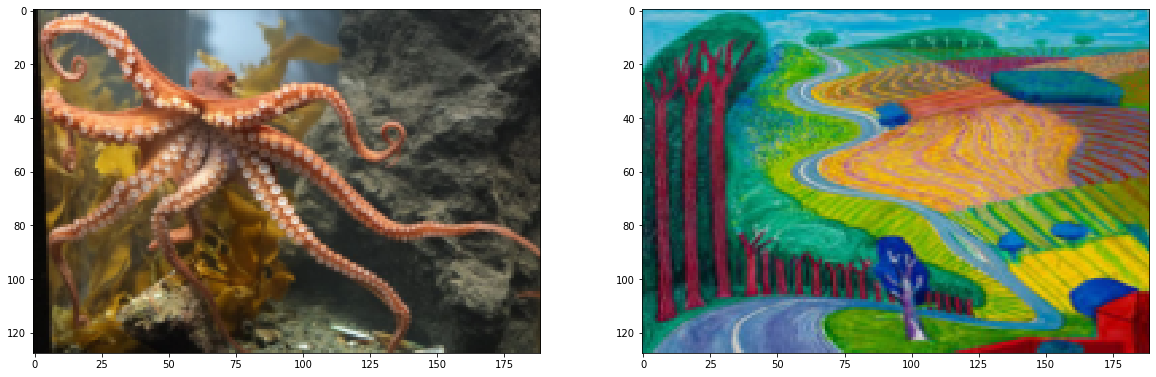

In [7]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

---
## VGG19 Layers


In [8]:
# print out VGG19 structure so you can see the names of various layers
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Content and Style Features


## 실습하기
아래에서 **content representation** 및 **style representation**에 레이어 이름 매핑을 완료해야 한다.

In [9]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

---
## Gram Matrix 

## 실습하기
Gram matrix는 기본적으로 하나의 layer에서 각 feature map 들 사이의 유사도를 측정한다.

The Gram matrix는 다음과 같이 계산된다.

* `batch_size, d, h, w = tensor.size` 를 사용하여 텐서의 batch_size, depth, height, width 정보를 가져온다.
* flatten: tensor를 1차원으로 Reshape한다.
* gram matrix는 reshape된 tensor와 자신의 transpose 을 matrix multiply 해서 구한다.

**Note: 두개의 matrix는 `torch.mm(matrix1, matrix2)`로 구한다.**

In [10]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

## Putting it all Together

주어진 컨볼루션 레이어의 특징을 추출하고 Gram Matrix 를 계산하는 함수를 작성했다. 이를 모두 합쳐서 이미지에서 feature를 추출하고 스타일 representaion 에서 각 레이어의 Gram Matrix 을 계산한다.

In [11]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

---
## Loss and Weights

#### Individual Layer Style Weights

각 관련 레이어에서 스타일 표현에 가중치를 부여하는 옵션을 줄 수 있다. 레이어의 가중치는 0에서 1 사이의 범위를 사용하는 것이 좋다.  `conv1_1` 및`conv2_1`에 가중치를 더 많이 부여하면 최종 target 이미지에서 더 많은 style의 artifacts를 반영할 수 있다. 

#### Content and Style Weight

alpha (`content_weight`)와 beta (`style_weight`)를 정의한다. 이 비율은 최종 이미지의 스타일에 영향을 준다. content_weight = 1을 그대로 두고 원하는 비율을 달성하도록 style_weight를 설정하는 것이 좋다.


In [12]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

## Updating the Target & Calculating Losses

## 실습하기

이미지를 업데이트하기위한 여러 단계를 설정해야 한다.  
target_ 이미지 만 변경하고 VGG19 또는 다른 이미지는 변경하지 않는다. 
좋은 결과를 얻으려면 최소 2000 steps 를 사용하는 것이 좋다. 그러나 처음에는 훨씬 적은 step 수 부터 실행해야 훈련에 걸리는 시간을 줄일 수 있다.  

반복 루프 내에서 컨텐츠 및 스타일 손실을 계산하고 이에 따라 target 이미지를 업데이트한다.

#### Content Loss

콘텐츠 loss는 'conv4_2'레이어에서 target과 content feature 간의 MSE로 구한다.
```
content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
```

#### Style Loss

style loss 는 target 이미지와 Style 이미지 사이의 loss이다. 즉, style image의 gram matrix와 target image의 gram matrix 의 차이를 말한다. Loss는 MSE를 사용하여 계산한다.

#### Total Loss

마지막으로 스타일과 콘텐츠 손실을 합산하고 지정된 알파 및 베타로 가중치를 적용하여 총 loss를 계산한다.

Total loss:  76687080.0


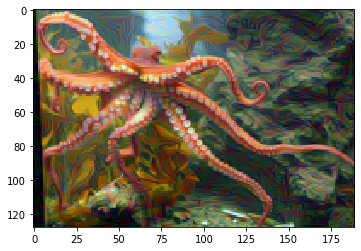

Total loss:  45387084.0


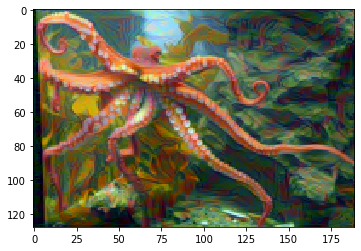

Total loss:  31393842.0


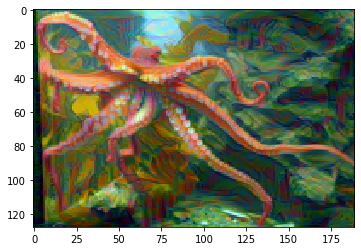

Total loss:  21984930.0


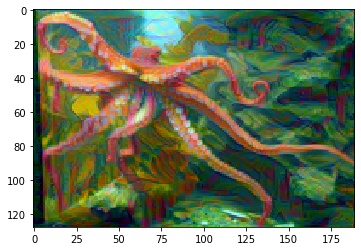

Total loss:  15142243.0


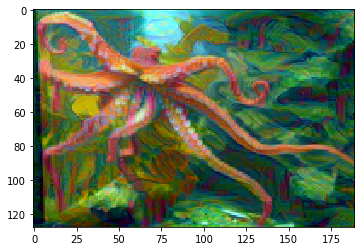

In [13]:
# for displaying the target image, intermittently
show_every = 100 # (400)

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 500  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

## Display the Target Image

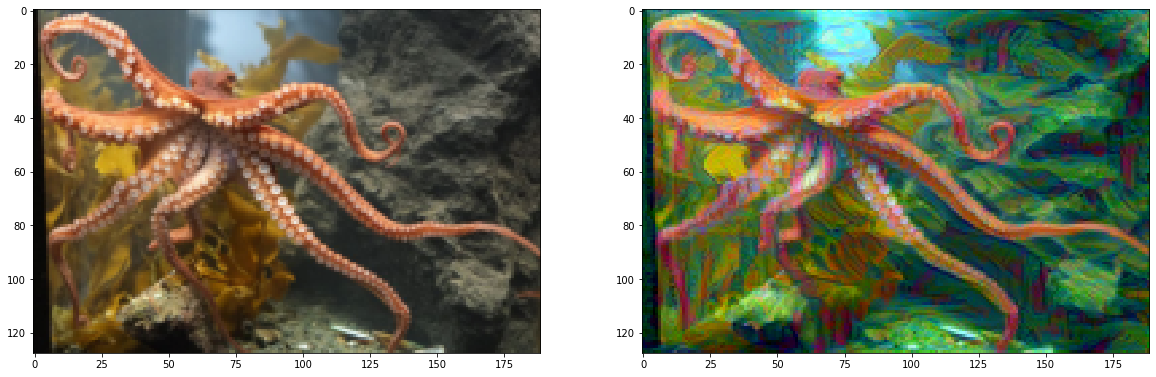

In [14]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))